<a href="https://colab.research.google.com/github/lauraciurca/Contradiction-Project/blob/main/FEATURE_EXTRACTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

In [1]:
import pandas as pd
import re
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from nltk.corpus import wordnet as wn
from nltk import Tree
import nltk
nltk.download('averaged_perceptron_tagger')
from textblob import TextBlob
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('tagsets')
from nltk.tokenize import word_tokenize
import pandas as pd
!pip install -q swifter
!pip install -q pysentiment2
import swifter
import pysentiment2 as ps
from textblob import TextBlob
import spacy
import gensim
from gensim import models
!pip install nltk

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
     |████████████████████████████████| 296 kB 7.9 MB/s 
     |████████████████████████████████| 125 kB 59.6 MB/s 
     |████████████████████████████████| 1.9 MB 7.2 MB/s 


**Importing Data From Kaggle**

In [ ]:
#upload kaggle.json, containing the API to Google Colab
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"lauraciurca","key":"e915e9261627525499a9c986d85f589f"}'}

In [ ]:
!pip install -q kaggle
#move kaggle.json into the folder the API expects to find it
!mkdir -p ~/.kaggle             
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
#download contradictory-my-dear-watson dataset
!kaggle competitions download -c contradictory-my-dear-watson

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
training_set = pd.read_csv('/content/train.csv')
test_set = pd.read_csv('/content/test.csv')

**Data Analysis and Pre-Processing**

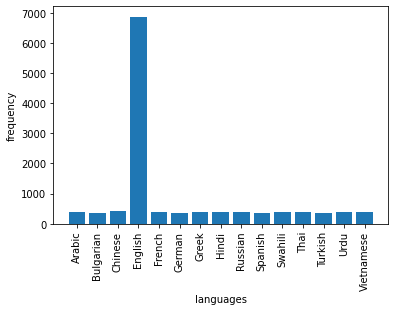

In [ ]:
#histogram to check language distribution
labels, frequencies = np.unique(training_set.language.values, return_counts = True)
x= labels
y= frequencies
plt.bar(x,y,align='center')
plt.xlabel('languages')
plt.ylabel('frequency')
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
#filter english words
training_set = training_set.loc[training_set['language'] == "English"]
test_set = test_set.loc[test_set['language'] == "English"]

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def visualize(target):
    words = ''
    for msg in training_set[training_set['label'] == target]['hypothesis']:
        msg = msg.lower()
        words += msg + ' '
    wordcloud = WordCloud(width=1000, height=1000, random_state=1, background_color='white').generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

visualize(0) #entailment
visualize(1) #neutral
visualize(2) #contradiction

In [ ]:
training_set = training_set.reset_index()
test_set = test_set.reset_index()

In [ ]:
training_set = training_set.drop(['index', 'lang_abv', 'language','id'], axis = 1)
test_set = test_set.drop(['index', 'lang_abv', 'language','id'], axis = 1)

In [ ]:
contraddizioni = training_set.loc[training_set['label'] == 2]
contraddizioni = contraddizioni.reset_index()
contraddizioni["premise"][5],contraddizioni["hypothesis"][5]

('He says men are here.', 'He said that the men were not here. ')

In [ ]:
print("Training set size: ",training_set.shape)
print("Test set size: ",test_set.shape)

Training set size:  (6870, 3)
Test set size:  (2945, 2)


In [ ]:
#check word distribution
#training_set["premise_count_words"] = training_set["premise"].apply(lambda x: len(str(x).split()))
#training_set["hypothesis_count_words"] = training_set["hypothesis"].apply(lambda x: len(str(x).split()))
#test_set["premise_count_words"] = test_set["premise"].apply(lambda x: len(str(x).split()))
#test_set["hypothesis_count_words"] = test_set["hypothesis"].apply(lambda x: len(str(x).split()))

(array([ 852., 2701., 2450.,  622.,  179.,   44.,   11.,    5.,    3.,
           3.]),
 array([ 1. ,  5.5, 10. , 14.5, 19. , 23.5, 28. , 32.5, 37. , 41.5, 46. ]),
 <a list of 10 Patch objects>)

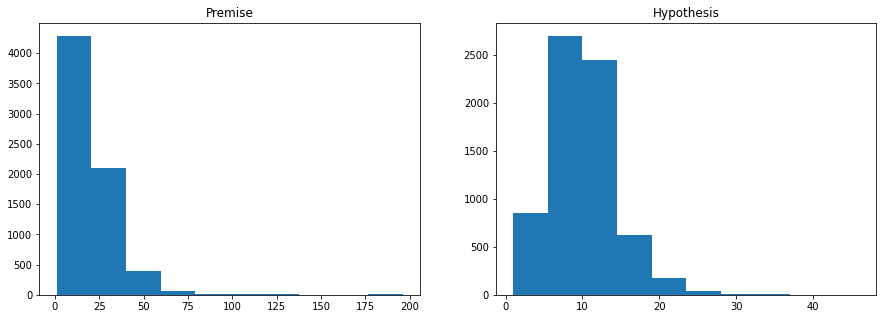

In [ ]:
fig = plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.title('Premise')
plt.hist(training_set['premise_count_words'])

plt.subplot(1,2,2)
plt.title('Hypothesis')
plt.hist(training_set['hypothesis_count_words'])

In [ ]:
#longest premise and hypothesis
longest_len = 0           
idx = 0
for index, row in training_set.iterrows():
    length = 3
    length += len(row.premise.split())
    length += len(row.hypothesis.split())
    if length > longest_len:
        longest_len = length
        idx = index
        
max_len = longest_len + 100
        
print(longest_len)
print(idx)
print(training_set.premise.values[idx])
print(f"length:{len(training_set.premise.values[idx].split())}")
print(training_set.hypothesis.values[idx])
print(f"length:{len(training_set.hypothesis.values[idx].split())}")

219
5704
yes they would they just wouldn't be able to own the kind of automobiles that they think they deserve to own or the kind of homes that we think we deserve to own we might have to you know just be able to i think if we a generation went without debt then the next generation like if if our our generation my husband and i we're twenty eight if we lived our lives and didn't become you know indebted like you know our generation before us that um the budget would balance and that we became accustomed to living with what we could afford which we wouldn't be destitute i mean we wouldn't be living on the street by any means but just compared to how spoiled we are we would be in our own minds but i feel like the generation after us would oh man it it would be so good it would be so much better it wouldn't be perfect but then they could learn to live with what what they could afford to save to buy and if you want a nicer car than that well you save a little longer
length:196
Society woul

In [ ]:
training_set.premise.values[1],training_set.hypothesis.values[1]

('These are issues that we wrestle with in practice groups of law firms, she said. ',
 'Practice groups are not permitted to work on these issues.')

In [ ]:
sets=[training_set,test_set]

In [ ]:
#cleaning function
def cleaner(sentence):
    sentence = " ".join(sentence.lower() for sentence in sentence.split())  #converting to lower case
    sentence = re.sub('\s+', ' ', sentence)                                 #remove double spaces
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)                       #remove punctuation

    return sentence

In [ ]:
#cleaning all sets
for i in sets:
  i["premise"] = i["premise"].map(lambda x: cleaner(x))
  i["hypothesis"] = i["hypothesis"].map(lambda x: cleaner(x))

In [ ]:
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "i had / i would",
"i'd've": "i would have",
"i'll": "i shall / i will",
"i'll've": "i shall have / I will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
def expand_contractions(string):
  for word in string.split():
    if word in contractions:
        string = string.replace(word, contractions[word])
  return string

In [ ]:
def change_contractions(data):
  lsts=[]
  lsts1=[]
  for i in range(len(data)):
    x=expand_contractions(data.premise[i])
    y=expand_contractions(data.hypothesis[i])
    lsts.append(x)
    lsts1.append(y)
  data['premise'] = lsts
  data['hypothesis'] = lsts1
  return data

In [ ]:
for set in sets:
  set = change_contractions(set)

In [ ]:
results_training=training_set.copy()
results_test=test_set.copy()

**Feature Extraction**

Sentence Similarity

In [ ]:
!pip install pyemd

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-10-24 10:47:29--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  75.4MB/s    in 21s     

2021-10-24 10:47:50 (73.8 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
!gzip -d GoogleNews-vectors-negative300.bin.gz

gzip: GoogleNews-vectors-negative300.bin already exists; do you wish to overwrite (y or n)? N
	not overwritten


In [ ]:
#load word2vec model, here GoogleNews is used
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
def sentence_distance(data):
  wmdistance=[]
  for x in range(len(data)):
    f=data["premise"][x]
    s=data["hypothesis"][x]
    distance = model.wmdistance(f, s)
    wmdistance.append(distance)
  return wmdistance

In [ ]:
training_set["sentence_sim"] = sentence_distance(training_set)
test_set["sentence_sim"] = sentence_distance(test_set)

In [ ]:
#wm= training_set.loc[training_set['label'] == 2]
#wm["sentence_distance"].value_counts()
#wm

Cosine similarity

In [ ]:
#define cosine function
def determine_cosine(s1,s2):
  w1=s1.split()       
  w2=s2.split()
  a = {e for e in w1}
  b = {e for e in w2}
  uw=a.union(b)
  nuw=list(uw)
  v1=[]
  v2=[]
  for x in range(len(uw)):
    if(nuw[x] in w1):
        v1.append(1)
    else:
        v1.append(0)
  for x in range(len(uw)):
    if(nuw[x] in w2):
        v2.append(1)
    else:
        v2.append(0)
  cosine_similarity = 1 - distance.cosine(v1, v2)
  return cosine_similarity


In [ ]:
def apply_cosine(data):
 cosine_similarity=[]
 for i in range(len(data)):
   s1 = data["premise"][i]
   s2 = data["hypothesis"][i]
   sim = determine_cosine(s1,s2)
   cosine_similarity.append(sim)
 data["cosine_similarity"]=cosine_similarity

In [ ]:
apply_cosine(training_set)
apply_cosine(test_set)

In [ ]:
cosine= training_set.loc[training_set['label'] == 2]
cosine.head()

,premise,hypothesis,label,cosine_similarity
1,these are issues that we wrestle with in pract...,practice groups are not permitted to work on t...,2,0.408248
3,from cockpit country to st ann s bay,from st ann s bay to cockpit country,2,1.000000
8,the streets are crammed with vendors selling s...,vendors have lined the streets with torches an...,2,0.382360
9,north of mytilini stop at the village of moria...,there is nothing special to see in the village...,2,0.263181
13,savonarola burned in florence,florence became savonarola s new home,2,0.408248


Jaccard similarity

In [ ]:
def get_jaccard_sim(str1, str2): 
    a = str1.split()
    b = {word for word in a}
    c = str2.split() #{e for e in str1}
    d = {word for word in c} #{e for e in str2}
    e = b.intersection(d)
    return float(len(e)) / (len(c) + len(d) - len(e))

In [ ]:
def apply_jaccard(data):
  listi = []
  for i in range(len(data)):
     x=get_jaccard_sim(data.premise[i], data.hypothesis[i])
     listi.append(x)

  data['jacard'] = listi
  data.jacard.value_counts()


In [ ]:
for set in sets:
  set = apply_jaccard(set)

In [ ]:
#jacard= training_set.loc[training_set['label'] == 2]
#jacard.head()

,premise,hypothesis,label,jacard
1,these are issues that we wrestle with in pract...,practice groups are not permitted to work on t...,2,0.333333
3,from cockpit country to st ann s bay,from st ann s bay to cockpit country,2,1.000000
8,the streets are crammed with vendors selling s...,vendors have lined the streets with torches an...,2,0.384615
9,north of mytilini stop at the village of moria...,there is nothing special to see in the village...,2,0.222222
13,savonarola burned in florence,florence became savonarola s new home,2,0.200000


Negation feature

In [ ]:
dict_neg = ["no","non","not","nothing","no one","without","nobody","cannot", "anyone"]  

In [ ]:
def negation_in_a_sentence(str1):
  a = str1.split()
  sett = {e for e in a}                         
  for word in sett:
    if word in dict_neg:
      return True
  return False

In [ ]:
def checking_contraddiction(str1,str2):
  if negation_in_a_sentence(str1)==negation_in_a_sentence(str2):
    return 0                #not contradiction
  else:
    return 1                #cotradiction

In [ ]:
def assign_contraddiction(set):
  l=[]
  for i in range(len(set)):
    p=checking_contraddiction(set.premise[i], set.hypothesis[i])
    l.append(p)
  set['contraddiction']=l

In [ ]:
for set in sets:
  set = assign_contraddiction(set)

In [ ]:
training_set["contraddiction"].value_counts()

0    5520
1    1350
Name: contraddiction, dtype: int64

Numeric feature

In [ ]:
#function for identifying numeric values
def has_numbers(inputString):
    return any(char.isdigit() for char in inputString) 

In [ ]:
#checking for the amount of numeric features in sentences
l = []
for x in training_set["hypothesis"]:
    count_numbers= has_numbers(x)        #14% of the entire dataset
    l.append(count_numbers)
print(sum(l))                                   

443


In [ ]:
def count_numbers(data):
  premise_count=[]
  for i in data["premise"]:
     txt= [int(s) for s in i.split() if s.isdigit()]
     if len(txt):
       y=txt[0] 
       premise_count.append(y)
     else: 
       y=0 
       premise_count.append(y)
  hypothesis_count=[]
  for i in data["hypothesis"]:
     txt= [int(s) for s in i.split() if s.isdigit()]
     if len(txt):
       y=txt[0] 
       hypothesis_count.append(y)
     else: 
       y=0 
       hypothesis_count.append(y)
  numeric_similarity=[]
  for i in range(len(data)):
    if  premise_count[i]==0 or hypothesis_count[i]==0:
      m=0
      numeric_similarity.append(m)
    elif premise_count[i]==hypothesis_count[i]:
      y=1
      numeric_similarity.append(y)
    else: 
      f=-1
      numeric_similarity.append(f)
  data["numeric_similarity"]=numeric_similarity  

In [ ]:
for set in sets:
  count_numbers(set)

In [ ]:
training_set.numeric_similarity.value_counts()

 0    6573
 1     183
-1     114
Name: numeric_similarity, dtype: int64

In [ ]:
#final set features
training_set.head()

,premise,hypothesis,label,bleu,tf_idf,numeric_similarity
0,and these comments were considered in formulat...,the rules developed in the interim were put to...,0,0.000000,0.359425,0
1,these are issues that we wrestle with in pract...,practice groups are not permitted to work on t...,2,0.000000,0.149071,0
2,you know they can t really defend themselves l...,they can t defend themselves because of their ...,0,0.577350,0.169031,0
3,from cockpit country to st ann s bay,from st ann s bay to cockpit country,2,0.594604,1.000000,0
4,look it s your skin but you re going to be in ...,the boss will fire you if he sees you slacking...,1,0.000000,0.237496,0


Antonyms

In [ ]:
nltk.download('wordnet')
np = spacy.load('en')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 29.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
nlp= spacy.load('/usr/local/lib/python3.7/dist-packages/en_core_web_lg/en_core_web_lg-2.2.5')

In [ ]:
#Antonyms finder function
def word_antonyms(word):
    from nltk.corpus import wordnet
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.append(l.name())
            if l.antonyms():
                antonyms.append(l.antonyms()[0].name())
    print("Antonym:",set(antonyms))

In [ ]:
def check_contradiction(antonym_tracker,negdoc1,negdoc2):
    temp_var=negdoc1+negdoc2+antonym_tracker
    if(temp_var%2!=0 and temp_var<3):
        return 1
    else:
        return 0

In [ ]:
negation_list_training=[]
negation_list_test=[]
for j in range(len(training_set)):                    #test_set
    sent1 = training_set["premise"][j]                #test_set
    sent2 = training_set["hypothesis"][j]             #test_set
    doc1 = np(sent1)
    doc2 = np(sent2)
    synonyms = []
    antonyms = []
    wrdlist=list()
    antony=list()
    contr_tracker=0
    antonym_tracker=0
    negdoc1=0
    negdoc2=0
    verb1=""
    verb2=""
    num_contr_tracker=0
    #Processing sentence 1
    for token in doc1:
     if(token.dep_=="neg"):
        negdoc1=1
        verb1+="NOT "
    #Storing the antonyms of root words
     if(token.pos_=="VERB" and token.dep_=="ROOT"):
        verb1+=token.lemma_
        word_antonyms(token.lemma_)
        for anton in antonyms:
            antony.append(anton)
    #Processing Sentence 2
    for token in doc2:
      if(token.dep_=="neg"):
        negdoc2=1
        verb2+="NOT "
      if(token.pos_ =="VERB" and token.dep_=="ROOT"):   #in ("VB","VBG", "VBD", "VBN", 'VBP','VBZ')
        verb2+=token.lemma_
        if(token.lemma_ in antony):
            antonym_tracker=1
    #Checking contradiction due to negation
    contr_tracker=check_contradiction(antonym_tracker,negdoc1,negdoc2)
    negation_list_training.append(contr_tracker)       #test

In [ ]:
training_set["antonym_negation"]=negation_list_training
#test_set["antonym_negation"]=negation_list_test

In [ ]:
test_set["antonym_negation"]=negation_list_test

In [ ]:
negation= training_set.loc[training_set['label'] == 0]
negation["antonym_negation"].value_counts()

0    2115
1     312
Name: antonym_negation, dtype: int64

In [ ]:
#doc1="I love this film"
#doc1=nlp(doc1)
#doc2="I hate this film"
#doc2=nlp(doc2)

In [ ]:
#for each in doc1:
#    print(f"{each.head}------{each.dep_}------>{each.text}({each.pos_})")

love------nsubj------>I(PRON)
love------ROOT------>love(VERB)
film------det------>this(DET)
love------dobj------>film(NOUN)


In [ ]:
#for each in doc2:
#    print(f"{each.head}------{each.dep_}------>{each.text}({each.pos_})")

hate------nsubj------>I(PRON)
hate------ROOT------>hate(VERB)
film------det------>this(DET)
hate------dobj------>film(NOUN)


In [ ]:
#spacy.displacy.render(doc2, jupyter=True)

Subject-subject similarity comparison

In [ ]:
#define those sentences according to the subject they refer to

In [ ]:
def parsed(data):
  parse=[]
  for sentence in data["premise"]:
    doc= np(sentence)                      
    parse.append(doc) 
  return parse

In [ ]:
def parsed2(data):
  parse2=[]
  for sentence2 in data["hypothesis"]:
    doc2=np(sentence2)                     
    parse2.append(doc2)
  return parse2

In [ ]:
def subject_in_sentence(data):
 subj_premise=[]
 subj_hypothesis=[]
 for doc in parsed(data):
   subjects=get_subject_phrase(doc)
   subj_premise.append(subjects)
 for doc in parsed2(data):
   subjects2=get_subject_phrase(doc)
   subj_hypothesis.append(subjects2)
 data["subj_premise"]=subj_premise
 data["subj_hypothesis"]=subj_hypothesis

In [ ]:
def get_subject_phrase(doc):
    for token in doc:
        if ("nsubj" or "nsubjpass" in token.dep_):
            subtree = list(token.subtree)
            start = subtree[0].i
            end = subtree[-1].i + 1
            return doc[start:end]

In [ ]:
subject_in_sentence(training_set)
#subject_in_sentence(test_set)

In [ ]:
changed=[]
for x in training_set["subj_premise"]:
  s=[]
  for word,pos in nltk.pos_tag(nltk.word_tokenize(str(x))):
    if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS' or pos =='PRP' or pos == 'PRP$'):  
      s.append(word)
  changed.append(s)

In [ ]:
training_set["subj_premise"]=changed

In [ ]:
changed2=[]
for x in training_set["subj_hypothesis"]:
  s2=[]
  for word,pos in nltk.pos_tag(nltk.word_tokenize(str(x))):
    if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS' or pos =='PRP' or pos == 'PRP$'): 
      s2.append(word)
  changed2.append(s2)

In [ ]:
training_set["subj_hypothesis"]=changed2

In [ ]:
comparison=[]

premise_syn=[]
hypoth_syn=[]
for z in range(len(training_set)):
  if training_set["subj_premise"][z] and training_set["subj_hypothesis"][z]:
    x = training_set["subj_premise"][z][0] 
    xsyn = wn.synsets(x)[:]
    premise_syn.append(xsyn)
    y = training_set["subj_hypothesis"][z][0] 
    ysyn = wn.synsets(y)[:]
    hypoth_syn.append(ysyn)
  else:
    m = 0
    premise_syn.append(m)
    hypoth_syn.append(m)

In [ ]:
##average of synsets of premise and hypothesis for similarity

In [ ]:
all_sim=[]
for l in range(len(premise_syn)):
  single_one= premise_syn[l]
  single_one_hyp= hypoth_syn[l]
  if single_one ==[] or single_one==0 or single_one_hyp ==[] or single_one_hyp==0:
    all_sim.append(0)
  else:
    sims=[]
    for x in single_one:
      for z in single_one_hyp:
        sim = x.wup_similarity(z)
        if sim is None:
          sims.append(0)
        else:
          sims.append(sim)
    all_sim.append(sims)

In [ ]:
total_sim=[]
for x in range(len(all_sim)):
  each_list=all_sim[x]
  if each_list==[] or each_list==0:
    total_sim.append(0)
  else:
    avg_value= sum(each_list)/ len(each_list)
    total_sim.append(avg_value)

In [ ]:
training_set["subject_sim"]=total_sim

In [ ]:
subj= training_set.loc[training_set['label'] == 0]
subj["subject_sim"].value_counts()

0.000000    1957
1.000000      63
0.353588      63
0.625000      35
0.185808      11
            ... 
0.284314       1
0.197164       1
0.128746       1
0.194344       1
0.162179       1
Name: subject_sim, Length: 249, dtype: int64

In [ ]:
training_set.loc[training_set['subject_sim'] == 0]

,premise,hypothesis,label,subj_premise,subj_hypothesis,subject_sim
0,and these comments were considered in formulat...,the rules developed in the interim were put to...,0,[],[],0.0
1,these are issues that we wrestle with in pract...,practice groups are not permitted to work on t...,2,[],[practice],0.0
2,you know they can t really defend themselves l...,they can t defend themselves because of their ...,0,[you],[they],0.0
3,from cockpit country to st ann s bay,from st ann s bay to cockpit country,2,"[country, s, bay]","[ann, s, bay, country]",0.0
4,look it s your skin but you re going to be in ...,the boss will fire you if he sees you slacking...,1,"[it, your, skin]",[],0.0
...,...,...,...,...,...,...
6865,the results of even the most well designed epi...,all studies have the same amount of uncertaint...,2,[],[],0.0
6866,but there are two kinds of the pleasure of doi...,but there are two kinds of the pleasure of doi...,0,[],[],0.0
6867,the important thing is to realize that it s wa...,it cannot be moved now or ever,2,[],[it],0.0
6868,at the west end is a detailed model of the who...,the model temple complex is at the east end,2,[end],[],0.0


Sentence polarity

In [ ]:
hiv4 = ps.HIV4()

In [ ]:
def tags(x):
   text = hiv4.tokenize(x)
   score = hiv4.get_score(text)
   return score

In [ ]:
for x in sets:
  x['questionpos'] = x['hypothesis'].swifter.apply(lambda x :tags(x))
  x['questionpos2'] = x['premise'].swifter.apply(lambda x :tags(x))
  x['questionpos'] = x['hypothesis'].swifter.apply(lambda x :tags(x))
  x['questionpos2'] = x['premise'].swifter.apply(lambda x :tags(x)) 

Pandas Apply:   0%|          | 0/6870 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6870 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6870 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6870 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2945 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2945 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2945 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2945 [00:00<?, ?it/s]

In [ ]:
for x in sets:
  x1= pd.DataFrame(x.questionpos.apply(lambda x:str(x).split(',',4)).tolist(), index= x.index)
  x2=pd.DataFrame(x.questionpos2.apply(lambda x:str(x).split(',',4)).tolist(), index= x.index)
  x['Positive_hypothesis']=x1[0].str.extract('([0-9]+[,./]*[0-9]*)', expand=False)
  x['Negative_hypothesis']=x1[1].str.extract('([0-9]+[,./]*[0-9]*)', expand=False)
  x['Polarity_hypothesis']=x1[2].str.extract('([0-9]+[,./]*[0-9]*)', expand=False) 
  x['Positive_premise']=x2[0].str.extract('([0-9]+[,./]*[0-9]*)', expand=False)
  x['Negative_premise']=x2[1].str.extract('([0-9]+[,./]*[0-9]*)', expand=False)
  x['Polarity_premise']=x2[2].str.extract('([0-9]+[,./]*[0-9]*)', expand=False)

In [ ]:
 #Create a function to get TextBlob the polarity
 #def getPolarity(text):
 #  return TextBlob(text).sentiment.polarity

In [ ]:
#def apply_textblob_polarity(data):
#  listi = []
#  for i in range(len(data)):
#     sentence = data[i]
#     x=getPolarity(sentence)
#     listi.append(x)
#  return listi

In [ ]:
#training_set["txtblb_pol_premise"]= apply_textblob_polarity(training_set["premise"])
#training_set["txtblb_pol_hypothesis"]= apply_textblob_polarity(training_set["hypothesis"])

In [ ]:
def polarity_comparison(data):
  polarity_list=[]
  for x in range(len(data)):
    polarity_premise= float(data["Polarity_premise"][x])
    polarity_hypothesis= float(data["Polarity_hypothesis"][x])
    if polarity_premise>= 0.5 and polarity_hypothesis < 0.5:                      #polarity_premise>= 0.0 and polarity_hypothesis   textBlob
      polarity_list.append(1)
    elif polarity_premise< 0.5 and polarity_hypothesis >= 0.5:                    #polarity_premise< 0.0 and polarity_hypothesis >= 0.0  textblob
      polarity_list.append(1)
    else:
      polarity_list.append(0)
  return polarity_list

In [ ]:
training_set["polarity"]=polarity_comparison(training_set)
test_set["polarity"]=polarity_comparison(test_set)

In [ ]:
def polarity_difference(data):
  polarity_list=[]
  for x in range(len(data)):
    polarity_premise= float(data["Polarity_premise"][x])
    polarity_hypothesis= float(data["Polarity_hypothesis"][x])
    difference = polarity_premise - polarity_hypothesis                   
    polarity_list.append(difference)
  return polarity_list

In [ ]:
training_set["polarity_difference"]=polarity_difference(training_set)
test_set["polarity_difference"]=polarity_difference(test_set)

In [ ]:
#polarity= training_set.loc[training_set['label'] == 2]
#polarity["polarity"].value_counts()

0    1320
1     957
Name: polarity, dtype: int64

From-to Comparison

In [ ]:
#checking from-to cases present in dataset
c=[]
for line in training_set["premise"]:
    count = sum(1 for match in re.finditer(r"\bfrom(.*)to\b", line))       #it is just 0,2% of the entire dataset
    c.append(count)
sum(c)

171

Export File inluding all Features

In [ ]:
columns=["wordnet_sim","cosine_similarity","jacard","contraddiction","tf_idf","bleu","numeric_similarity","count_antonyms","Positive","Negative","Polarity","Subjectivity","label"]

In [ ]:
columnss=["wordnet_sim","cosine_similarity","jacard","contraddiction","tf_idf","bleu","numeric_similarity","count_antonyms","Positive","Negative","Polarity","Subjectivity"]

In [ ]:
cols=["premise","hypothesis","label"]

In [ ]:
colsss=["premise","hypothesis"]

In [ ]:
#train= training_set[columns]
data_train=training_set[cols]
#test= test_set[columnss]
data_test=test_set[colsss]

In [ ]:
train.to_csv('train.csv')
data_train.to_csv('data_train.csv')
test.to_csv('test.csv')
data_test.to_csv('data_test.csv')

In [ ]:
data_train.to_csv('data_train.csv')
data_test.to_csv('data_test.csv')